## Annotation enrichemts
annotations done with VEP, checking to see if any annotaiton classes are enriched for pcqlts vs eqtls

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress


from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [6]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

# load data

In [7]:
# load in the data from all tissues
vep_df = load_across_tissues(config, load_vep)
vep_df.columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO',
       'cs_full_id', 'variant_list', 'lead_variant_id', 'cluster_id',
       'orig_cs_dataset', 'e_samelead', 'pc_samelead', 'num_e_samelead',
       'num_pc_samelead', 'e_overlap', 'pc_overlap', 'num_e_overlap',
       'num_pc_overlap', 'e_samelead_all', 'pc_samelead_all',
       'num_e_samelead_all', 'num_pc_samelead_all', 'e_overlap_all',
       'pc_overlap_all', 'num_e_overlap_all', 'num_pc_overlap_all',
       'var_cluster', 'pc_num', 'cluster_size', 'lead_variant_pos', 'pc_order',
       'tissue_id'],
      dtype='object')

In [8]:
# test out removing 1 var credible sets??
vep_df['num_vars'] = vep_df['variant_list'].apply(ast.literal_eval).apply(len)
print(len(vep_df))
vep_df = vep_df[vep_df['num_vars']>1]
print(len(vep_df))


41146
33078


In [9]:
# load in the gene information 
gid_gencode, full_gencode = load_gencode()

In [10]:
sns.countplot(vep_df, x='exclusive_label')

ValueError: Could not interpret value `exclusive_label` for `x`. An entry with this name does not appear in `data`.

<AxesSubplot: xlabel='pc_order', ylabel='Percent'>

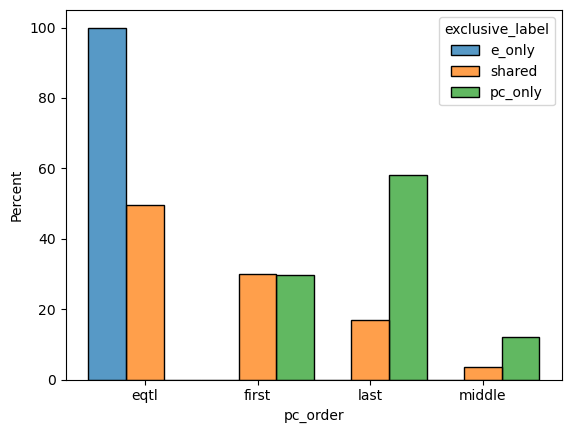

In [36]:
vep_df['exclusive_label'] = 'shared'
vep_df.loc[((vep_df['num_pc_overlap']>0) & (vep_df['num_e_overlap']==0)), 'exclusive_label'] = 'pc_only'
vep_df.loc[((vep_df['num_pc_overlap']==0) & (vep_df['num_e_overlap']>0)), 'exclusive_label'] = 'e_only'

sns.histplot(vep_df, hue='exclusive_label', x='pc_order', common_norm=False, multiple='dodge', stat='percent')

## VEP
vep annotates with variant categories

all the useful information is in the 'INFO' column:



Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS



* One info tags for each transcript the variant impacts, these are seperated by commas
* if an allele has multiple impacts on the same transcript, those appear to be listed with an &

In [ ]:
# as an example
vep_df.iloc[4].INFO

'CSQ=G|upstream_gene_variant|MODIFIER|AGRN|ENSG00000188157|Transcript|ENST00000379370|protein_coding||||||||||rs75267490|1468|1||HGNC|HGNC:329|ENST00000379370|0.2813|||||||||,G|upstream_gene_variant|MODIFIER|AGRN|ENSG00000188157|Transcript|ENST00000620552|protein_coding||||||||||rs75267490|1471|1||HGNC|HGNC:329|ENST00000379370|0.2813|||||||||,G|downstream_gene_variant|MODIFIER|ISG15|ENSG00000187608|Transcript|ENST00000624652|protein_coding||||||||||rs75267490|4217|1|cds_end_NF|HGNC|HGNC:4053|ENST00000379370|0.2813|||||||||,G|downstream_gene_variant|MODIFIER|ISG15|ENSG00000187608|Transcript|ENST00000624697|protein_coding||||||||||rs75267490|4112|1||HGNC|HGNC:4053|ENST00000379370|0.2813|||||||||,G|downstream_gene_variant|MODIFIER|ISG15|ENSG00000187608|Transcript|ENST00000649529|protein_coding||||||||||rs75267490|4112|1||HGNC|HGNC:4053|ENST00000379370|0.2813|||||||||'

In [ ]:
# a version with lists of the info fields, still only one row per cs
# I think this is better because, ie a variant would be listed as coding for each transcript its in, but I don't want to count each of those

def get_info_list(row, idx):
    return list(set([item.split('|')[idx] for item in row.INFO.split(',')]))

info_tags = 'Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS'
info_tags = info_tags.split('|')

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    vep_df[tag_name] = vep_df.apply(get_info_list, args=(i,), axis=1)

Allele


/local/scratch/klawren/slrmtmp.46623040/ipykernel_19280/2488332302.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vep_df[tag_name] = vep_df.apply(get_info_list, args=(i,), axis=1)


Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


In [ ]:
# make a list of the tissues for each ID
tissue_list = vep_df.groupby('ID')['tissue_id'].apply(list)
vep_df['tissue_list'] = vep_df['ID'].map(tissue_list)

/local/scratch/klawren/slrmtmp.46623040/ipykernel_19280/3889112286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vep_df['tissue_list'] = vep_df['ID'].map(tissue_list)


In [ ]:
# vep df should not be deduplicated I think
# just be sure to keep the orig dataset in mind 
#vep_df = vep_df.drop_duplicates('ID')

#### Consequence

In [ ]:
# some conseqeunces have an '&' in their name if multiple consequnces are prediced for the variant on the same transcript. 
# I will split those

def split_consequence(row):
    return list(set([indv_c for c in row['Consequence'] for indv_c in c.split('&')]))

vep_df['consequence_set'] = vep_df.apply(split_consequence, axis=1)

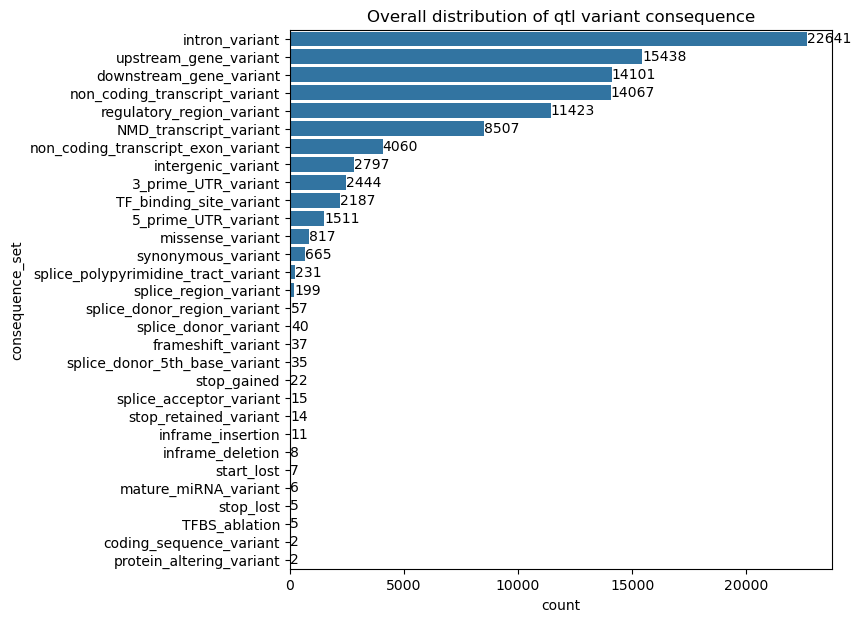

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ordered_c_categories = vep_df.explode('consequence_set')['consequence_set'].value_counts().index
y = sns.countplot(vep_df.explode('consequence_set'), y='consequence_set', ax=ax, order=ordered_c_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant consequence')
plt.show()

/local/scratch/klawren/slrmtmp.46623040/ipykernel_19280/1412881451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vep_df['cluster_size_clip'] = vep_df['cluster_size'].clip(0,5)


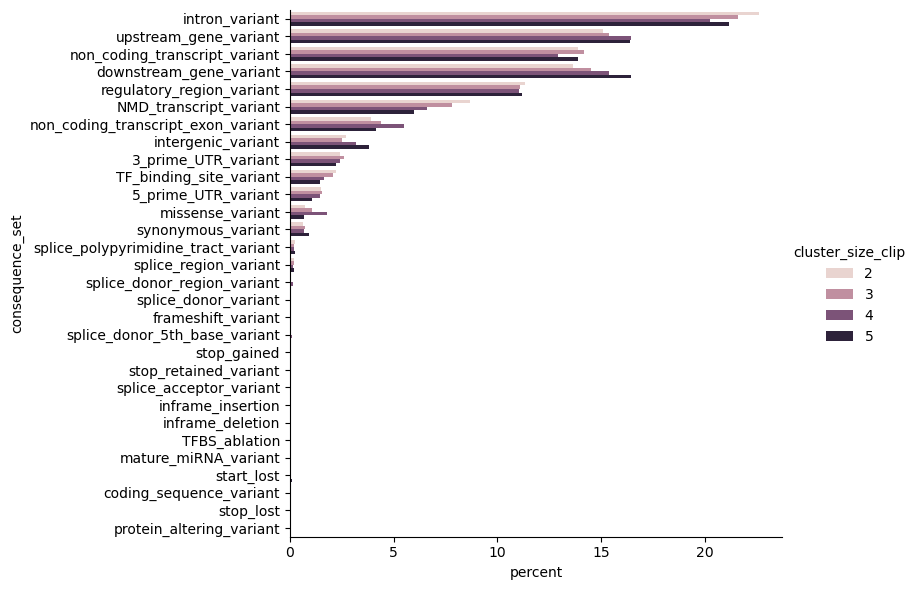

In [ ]:
vep_df['cluster_size_clip'] = vep_df['cluster_size'].clip(0,5)
data_to_plot = vep_df.explode('consequence_set').groupby('cluster_size_clip')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='cluster_size_clip',kind='bar',height=6, aspect=1.4)


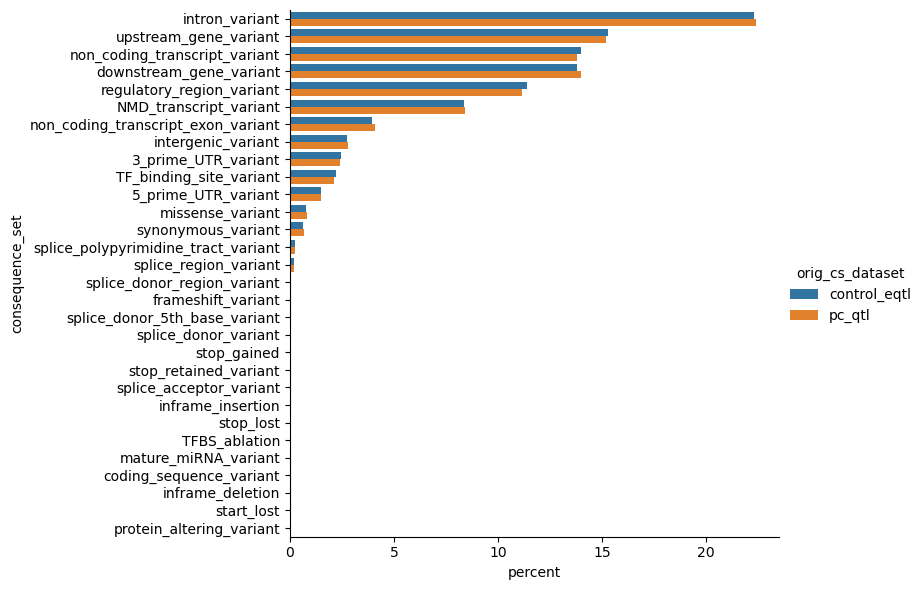

In [ ]:
data_to_plot = vep_df.explode('consequence_set').groupby('orig_cs_dataset')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='orig_cs_dataset',kind='bar', height=6, aspect=1.4)

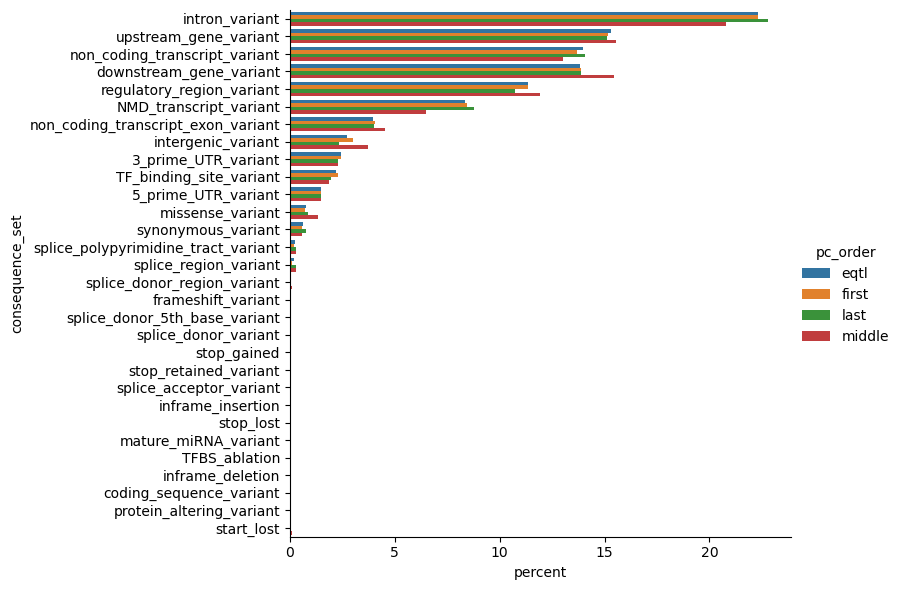

In [ ]:
data_to_plot = vep_df.explode('consequence_set').groupby('pc_order')['consequence_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='consequence_set',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


##### log odds

In [ ]:
# error bars on log odds come from error propegation for counts
def calculate_log_odds_error(counts1_positive, counts1_total, counts2_positive, counts2_total):
    counts1_negative = counts1_total-counts1_positive
    counts2_negative = counts2_total-counts2_positive

    # calculate the odds ratio
    or_ratio = (counts1_positive / counts1_negative) / (counts2_positive / counts2_negative)

    # calculate the standard error
    SE_log_OR = np.sqrt(1/counts1_positive - 1/counts1_negative + 1/counts2_positive - 1/counts2_negative)
    lower_bound, upper_bound = np.exp(np.log(or_ratio) - 1.96*SE_log_OR), np.exp(np.log(or_ratio) + 1.96*SE_log_OR)

    return np.log2(or_ratio), np.log2(lower_bound), np.log2(upper_bound)


def get_or_counts(vep_df, key_col='consequence_set'):
    return vep_df.explode(key_col).value_counts(key_col)

def get_odds_df(counts1, name1, counts2, name2, ordered_categories):
    or_df = pd.DataFrame({name1: counts1, name2: counts2})

    # add the odds ratios and 95% cis
    for idx in or_df.index:
        or_ratio, lower_bound, upper_bound = calculate_log_odds_error(or_df.loc[idx][name1], or_df[name1].sum(), or_df.loc[idx][name2], or_df[name2].sum())
        or_df.loc[idx, 'or_ratio'] = or_ratio
        or_df.loc[idx, 'lower_bound'] = lower_bound
        or_df.loc[idx, 'upper_bound'] = upper_bound

    or_df['upper_err_abs'] = or_df['upper_bound'] - or_df['or_ratio']
    or_df['lower_err_abs'] = or_df['or_ratio'] - or_df['lower_bound']
    return or_df.loc[ordered_categories[ordered_categories.isin(or_df.index)]].reset_index()

def plot_log_odds(or_df, title, key_col='consequence_set', ax=None, offset=-.2):
    if ax==None:
        fig, ax = plt.subplots(figsize=(7,7))
    # reset index to get consequence_set as a column

    ax.errorbar(y=or_df[key_col], x=or_df['or_ratio'], xerr=np.clip(or_df[['lower_err_abs', 'upper_err_abs']].values.transpose(), -3, 3), fmt="o")

    ax.invert_yaxis()
    plt.axvline(0, color='k')
    plt.text(.1, len(or_df)+offset, f'-> {or_df.columns[1]}')
    plt.text(-.1, len(or_df)+offset, f'{or_df.columns[2]} <-', horizontalalignment='right')
    plt.title(title)
    return ax

<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant consequences'}>

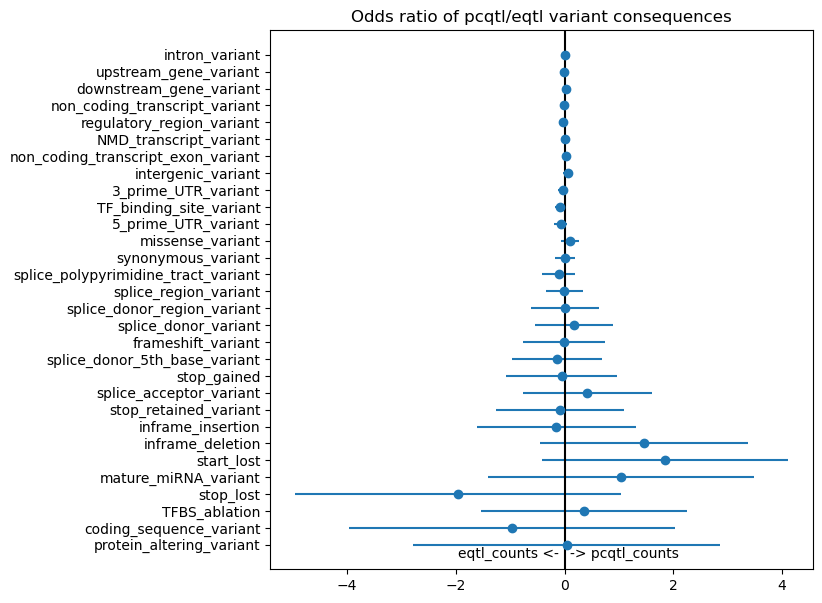

In [ ]:
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of exclusive eqtl/all eqtl variant consequences'}>

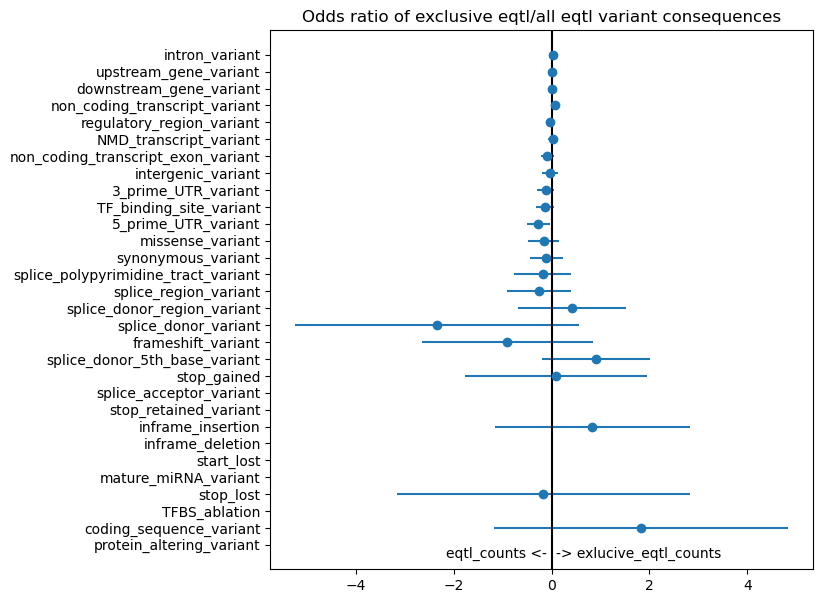

In [ ]:
exclusive_eqtl_counts = get_or_counts(vep_df[(vep_df['exclusive_label']=='e_only')])
eqtl_counts = get_or_counts(vep_df[(vep_df['orig_cs_dataset']=="control_eqtl")])

# format into a df and get the error bars
or_df = get_odds_df(exclusive_eqtl_counts, 'exlucive_eqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of exclusive eqtl/all eqtl variant consequences')

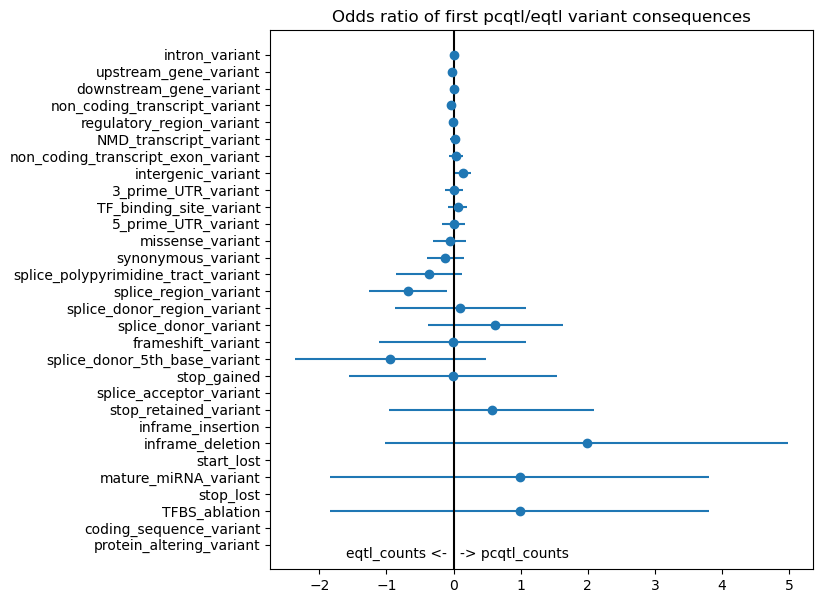

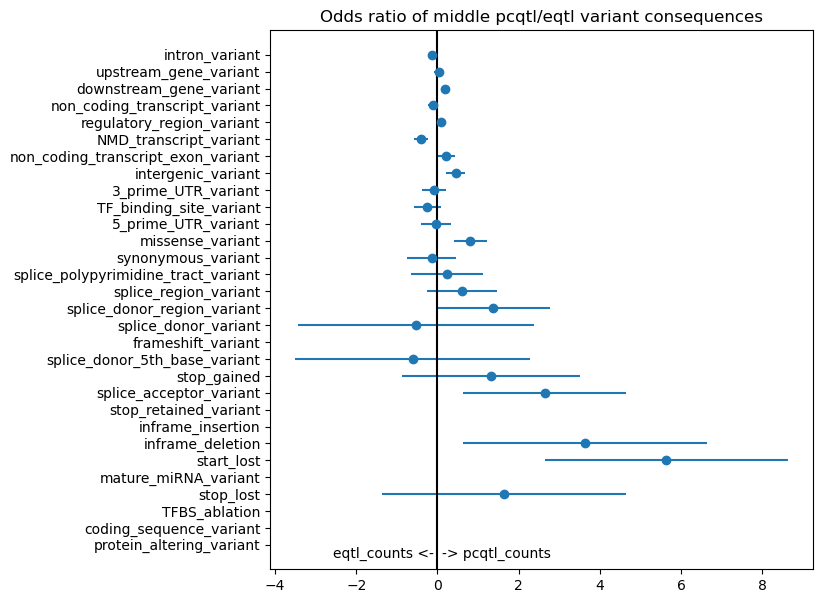

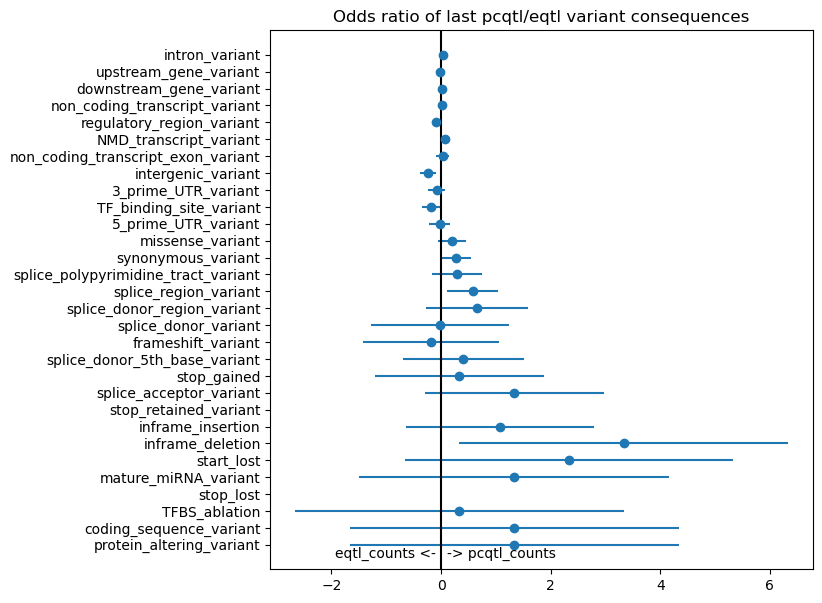

In [ ]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_order']==order)])
    eqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==0)])

    # format into a df and get the error bars
    or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_c_categories)

    # plot
    plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of first, middle pcqtl/last pcqtl variant consequences'}>

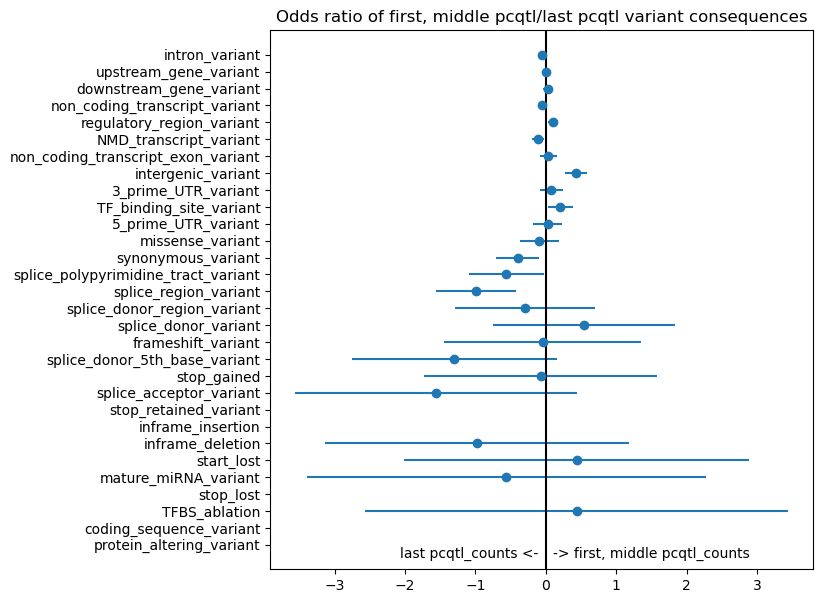

In [ ]:
# get counts for all pc1qtl  vs pc2qtl
pc1qtl_counts = get_or_counts(vep_df[(vep_df['pc_order'].isin(['first', 'middle']))])
pc2qtl_counts = get_or_counts(vep_df[(vep_df['pc_order']=='last')])

# format into a df and get the error bars
or_df = get_odds_df(pc1qtl_counts, 'first, middle pcqtl_counts', pc2qtl_counts, 'last pcqtl_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of first, middle pcqtl/last pcqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant consequences'}>

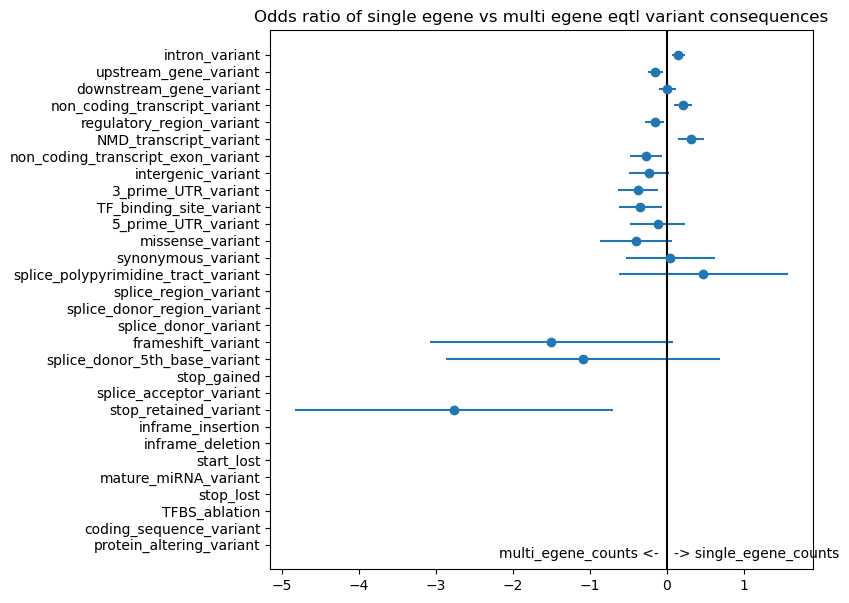

In [ ]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)])
multi_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)])

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant consequences')

### Biotype

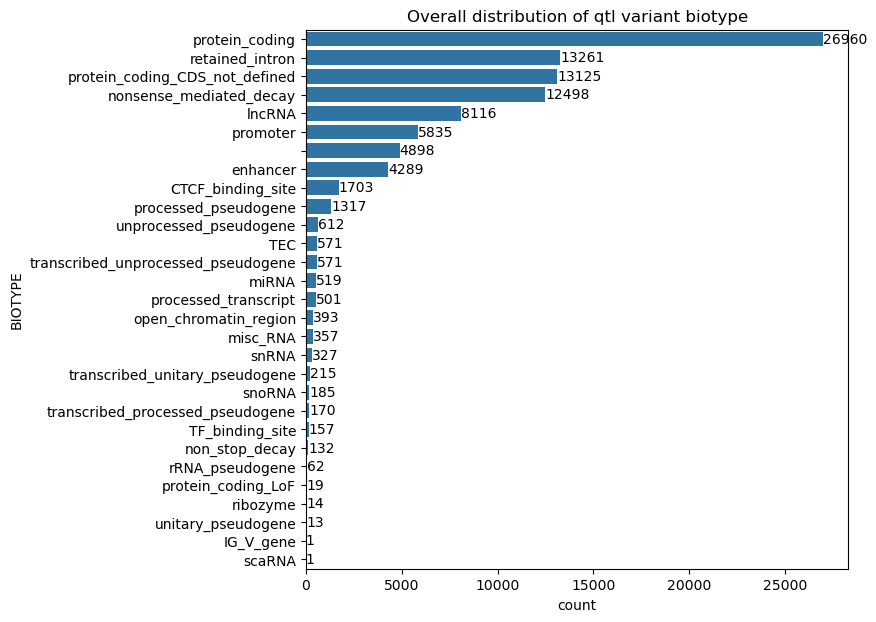

In [ ]:
# overall distribution of biotype
fig, ax = plt.subplots(figsize=(7,7))
ordered_b_categories = vep_df.explode('BIOTYPE')['BIOTYPE'].value_counts().index
y = sns.countplot(vep_df.explode('BIOTYPE'), y='BIOTYPE', ax=ax, order=ordered_b_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant biotype')
plt.show()

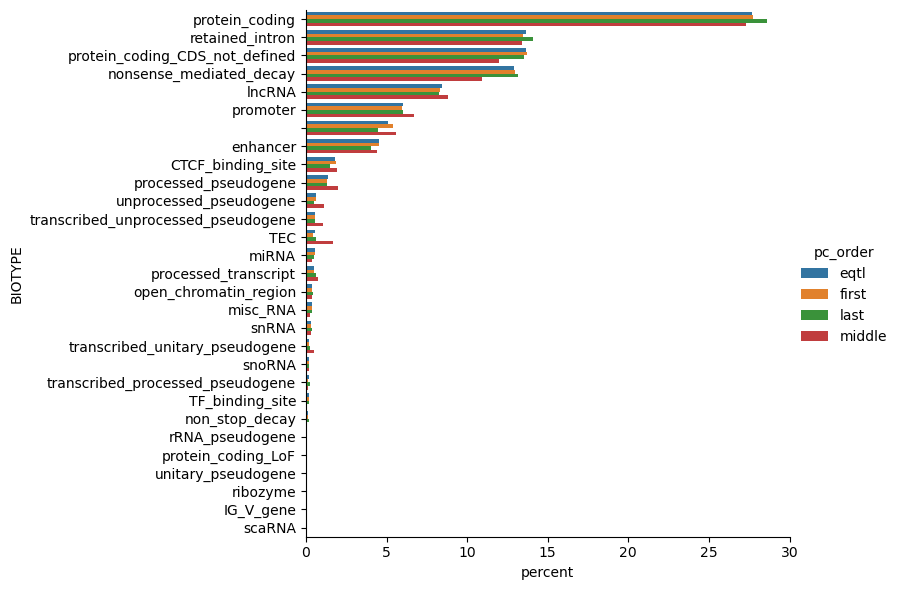

In [ ]:
data_to_plot = vep_df.explode('BIOTYPE').groupby('pc_order')['BIOTYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='BIOTYPE',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant biotype'}>

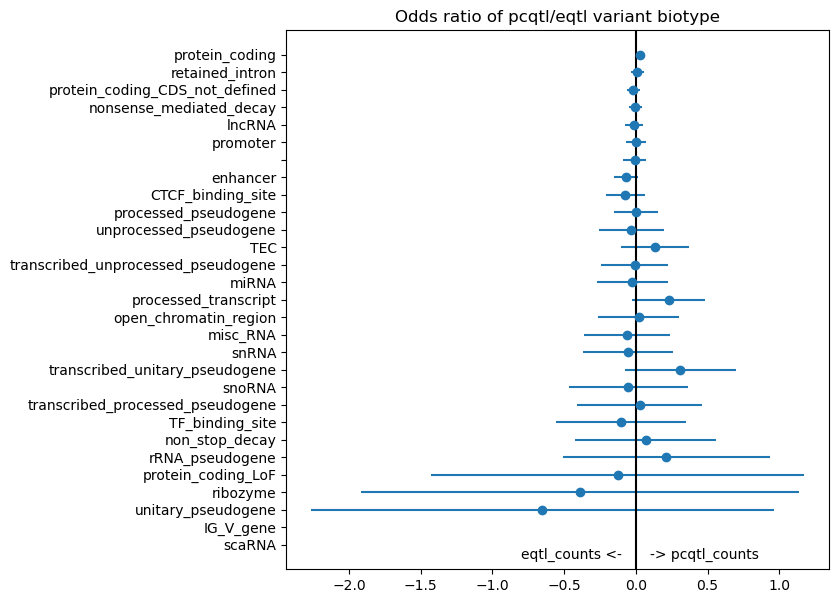

In [ ]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']>0)], key_col='BIOTYPE')
eqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==0)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant biotype', key_col='BIOTYPE')

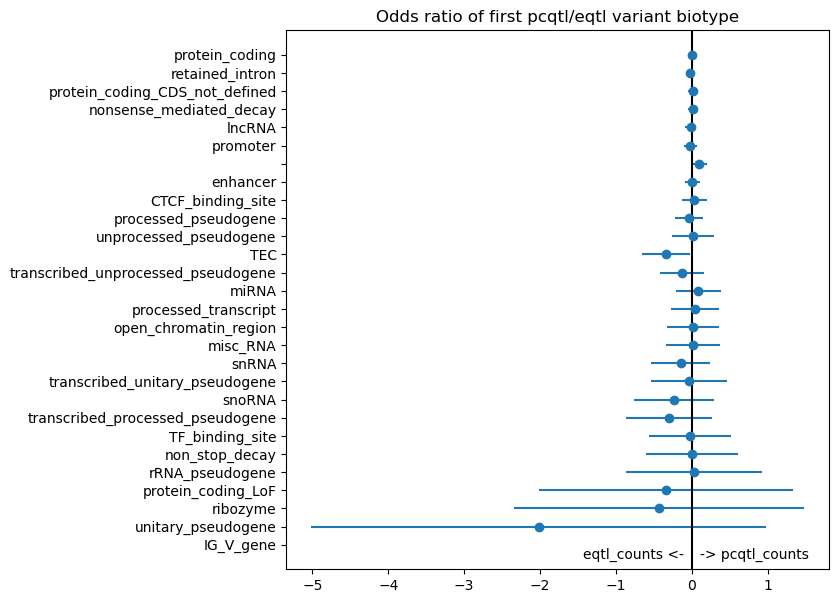

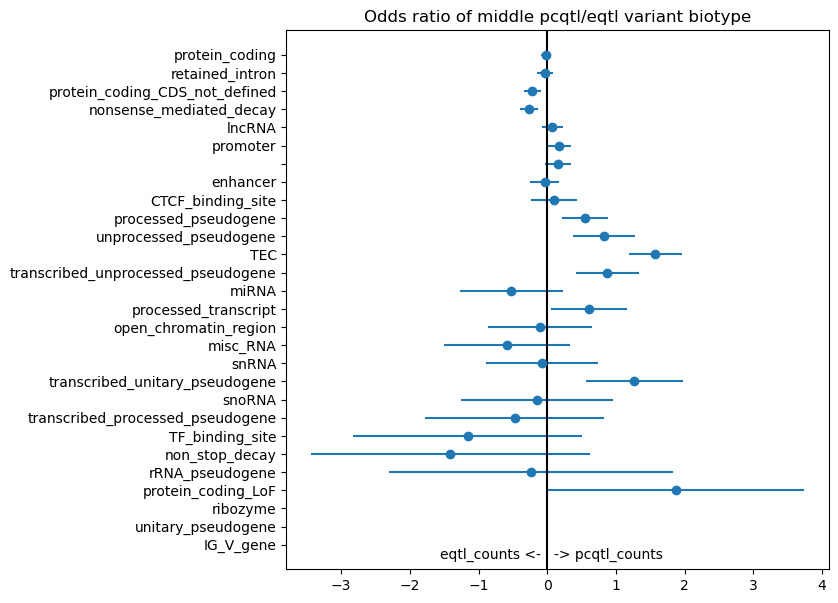

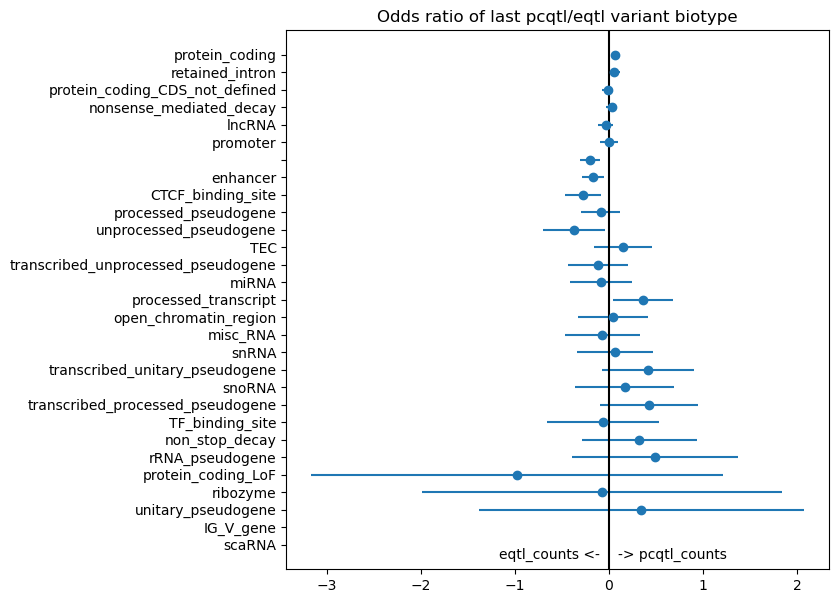

In [ ]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_order']==order)],  key_col='BIOTYPE')
    eqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==0)],  key_col='BIOTYPE')

    # format into a df and get the error bars
    or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_b_categories)

    # plot
    plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant biotype',  key_col='BIOTYPE')

In [11]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)], key_col='BIOTYPE')
multi_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant biotype', key_col='BIOTYPE')

NameError: name 'get_or_counts' is not defined

### Transcription factors

In [12]:
# TFs are split with :: and &
def split_tfs(row):
    split_tfs = [indv_tf for tf in row['TRANSCRIPTION_FACTORS'] for indv_tf in tf.split('&')]
    split_tfs = [indv_tf for tf in split_tfs for indv_tf in tf.split('::')]
    return list(set(split_tfs))

vep_df['tf_set'] = vep_df.apply(split_tfs, axis=1)

KeyError: 'TRANSCRIPTION_FACTORS'

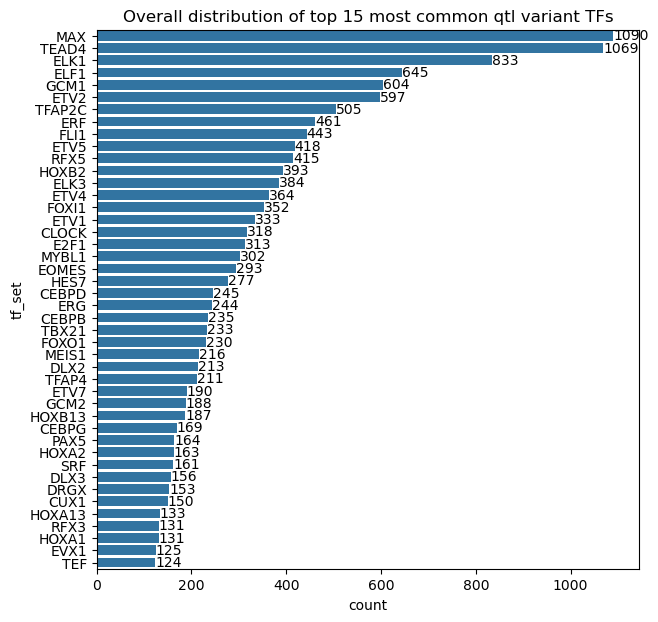

In [ ]:
# overall distribution of transcription factors
fig, ax = plt.subplots(figsize=(7,7))
ordered_t_categories = vep_df.explode('tf_set')['tf_set'].value_counts().index
subsample_df = vep_df.explode('tf_set')
subsample_df = subsample_df[subsample_df['tf_set'].isin(ordered_t_categories[1:45])]
y = sns.countplot(subsample_df, y='tf_set', ax=ax, order=ordered_t_categories[1:45])
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of top 15 most common qtl variant TFs')
plt.show()

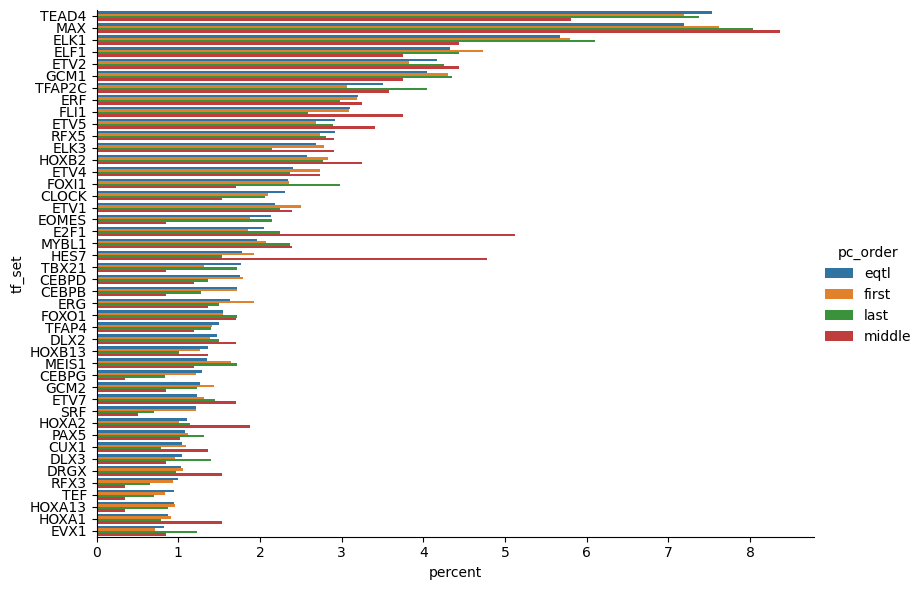

In [ ]:
data_to_plot = subsample_df.explode('tf_set').groupby('pc_order')['tf_set'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, y='tf_set',x='percent',hue='pc_order',kind='bar', height=6, aspect=1.4)


<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant tf'}>

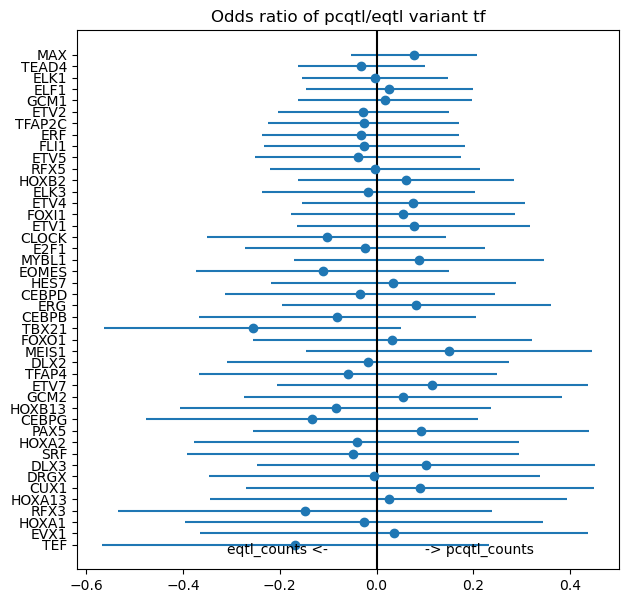

In [ ]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(subsample_df[(subsample_df['num_pc_samelead']>0)], key_col='tf_set')
eqtl_counts = get_or_counts(subsample_df[(subsample_df['num_e_samelead']>0)], key_col='tf_set')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_t_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant tf', key_col='tf_set')

## for presnetaitons

highlight a few interesting columns


**consequence**

NMD 

regulatory

TF binding

**biotype**

CTCF

enhancer

promotor

In [13]:
def selected_feature_or_df(df1, name1, df2, name2, features):
    # get biotype df
    df1_counts = get_or_counts(df1, key_col='BIOTYPE')
    df2_counts = get_or_counts(df2, key_col='BIOTYPE')

    # format into a df and get the error bars
    bio_or_df = get_odds_df(df1_counts, name1, df2_counts, name2 , ordered_categories=ordered_b_categories)

    # gert conseqeucne df
    df1_counts = get_or_counts(df1)
    df2_counts = get_or_counts(df2)

    # format into a df and get the error bars
    cons_or_df = get_odds_df(df1_counts, name1, df2_counts, name2, ordered_c_categories)

    # make into one df
    bio_or_df=bio_or_df.rename(columns={'BIOTYPE':'feature'})
    cons_or_df = cons_or_df.rename(columns={'consequence_set':'feature'})

    or_df = pd.concat([bio_or_df, cons_or_df])
    return or_df.set_index('feature').loc[features].reset_index()

In [14]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[vep_df['pc_num']>0], 'pcqtls', vep_df[vep_df['pc_num']==0], 'eqtls', features)



fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio pcqtls vs eqtls')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


NameError: name 'get_or_counts' is not defined

In [15]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[(vep_df['pc_num']>0)& vep_df['num_e_overlap']==0], 'exclusive pcqtls', vep_df[vep_df['pc_num']==0], 'eqtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of exclusive pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio exclusive pcqtls vs eqtls')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


NameError: name 'get_or_counts' is not defined

In [16]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']

or_df = selected_feature_or_df(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)], 'single_egene_counts', vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)], 'multi_egene_counts', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of single gene vs multigene eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


NameError: name 'get_or_counts' is not defined

In [17]:
# get counts for pcqtl vs all eqtls for different pc orders
for order in ['first', 'middle', 'last']:
    # format into a df and get the error bars
    or_df = selected_feature_or_df(vep_df[(vep_df['pc_order']==order)], 'pcqtl_counts', vep_df[(vep_df['pc_num']==0)], 'eqtl_counts', features)
    # plot
    ax = plot_log_odds(or_df, f'Odds ratio of {order} pcqtl/eqtl variant biotype',  key_col='feature')
    ax.set_xlim(-1.5, 1.5)


NameError: name 'get_or_counts' is not defined

# some other annotaiton categories
from data used in cluster annotations

* ABC enhancer
* CTCF site
* near tad boundry


pc eigenvalue

In [19]:
# from qtl_annotation_single_var
pc_df = pd.read_csv('{}/{}/pc_annotated.csv'.format(prefix, config['pc_output_dir']))

In [20]:
vep_df['phenotype_id'] = vep_df['cs_full_id'].str.split('_cs').str[0]
pc_vep_df = vep_df[vep_df['orig_cs_dataset']=='pc_qtl']
pc_vep_df = pd.merge(pc_vep_df, pc_df, left_on='phenotype_id', right_on = 'gene_id')


In [21]:
pc_df['has_pcqtl'] = pc_df['gene_id'].isin(vep_df['phenotype_id'].unique())
pc_df['has_unique_pcqtl'] = pc_df['gene_id'].isin(vep_df[vep_df['num_e_overlap']==0]['phenotype_id'].unique())
pc_df['qtl_label'] = np.where(pc_df['has_pcqtl'], np.where(pc_df['has_unique_pcqtl'], 'unique pcqtl', 'shared pcqtl'), 'no pcqtl')

In [22]:
pc_df['pc_num'] = pc_df['gene_id'].str.split('_pc').str[-1].astype(int)
pc_df['cluster_size'] = pc_df['gene_id'].str.split('_').apply(len) - 1
pc_df['pc_order'] = 'middle'
pc_df.loc[pc_df['pc_num'] == pc_df['cluster_size'],'pc_order'] = 'last'
pc_df.loc[pc_df['pc_num'] == 1,'pc_order'] = 'first'

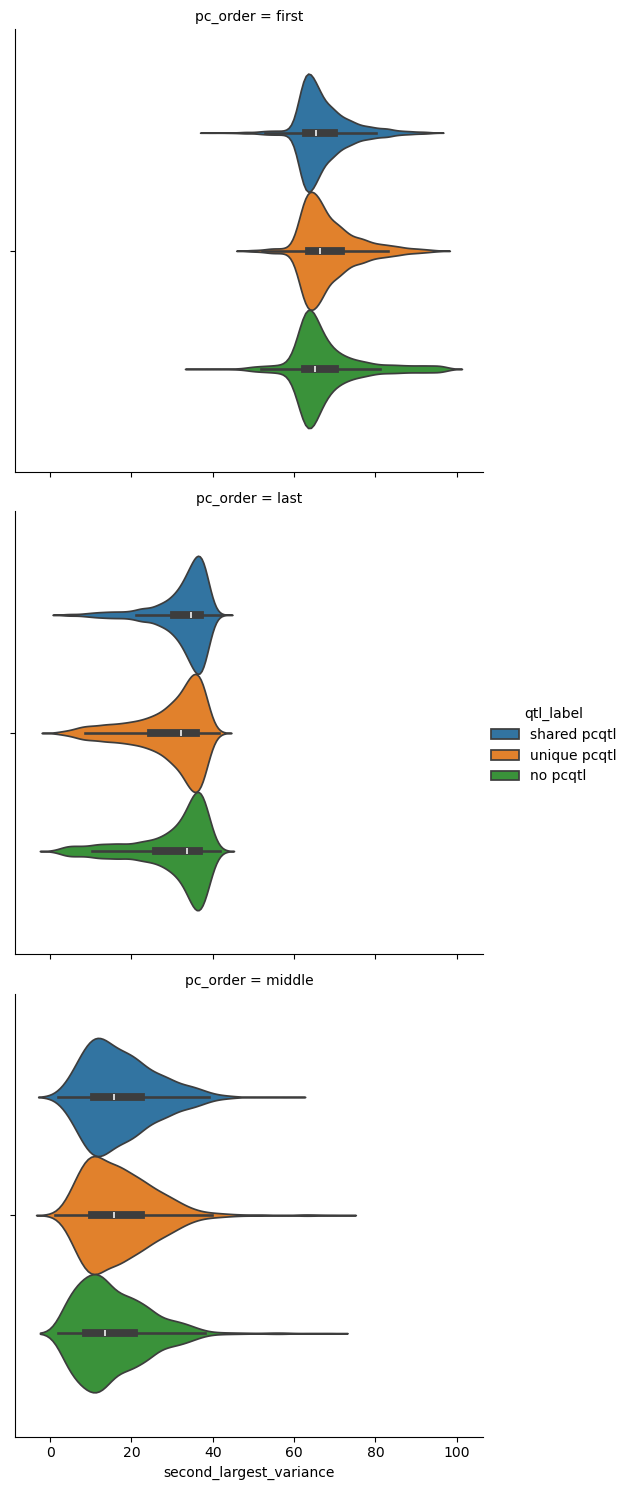

In [28]:
sns.catplot(pc_df, kind='violin', x='second_largest_variance', row='pc_order', hue='qtl_label')

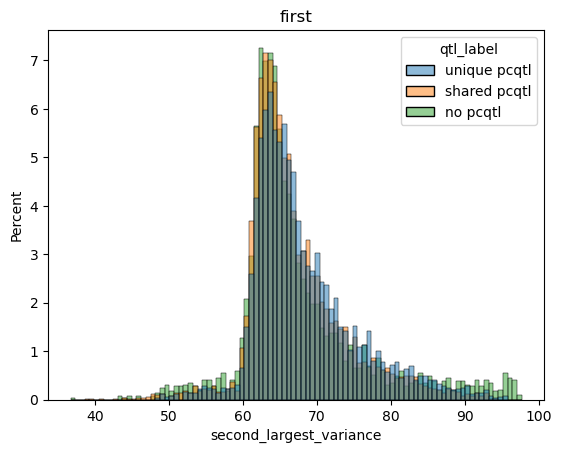

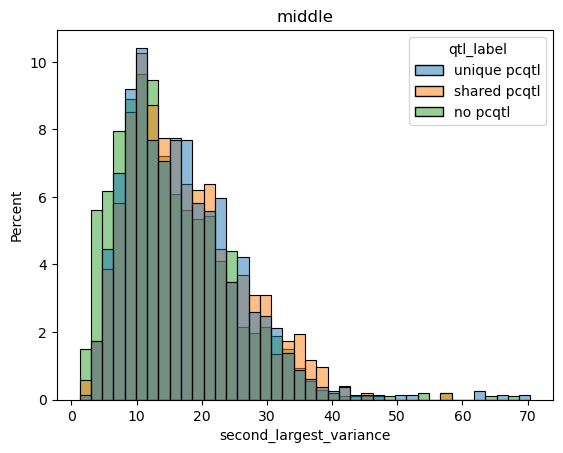

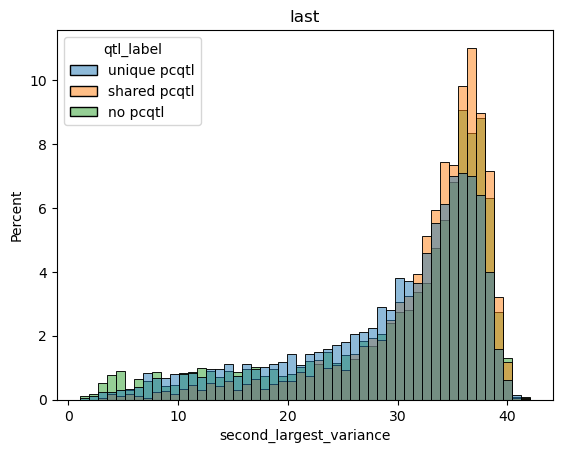

In [23]:
# are pcs that explain more varience more likely to have a pcqtl? 
for order in ['first', 'middle', 'last']:
    ax = sns.histplot(data=pc_df[pc_df['pc_order']==order], hue='qtl_label', 
                      x='second_largest_variance', common_norm=False, stat='percent', 
                      hue_order=['unique pcqtl', 'shared pcqtl', 'no pcqtl'])
    ax.set_title(order)

    plt.show()

<AxesSubplot: xlabel='largest_variance', ylabel='cluster_size'>

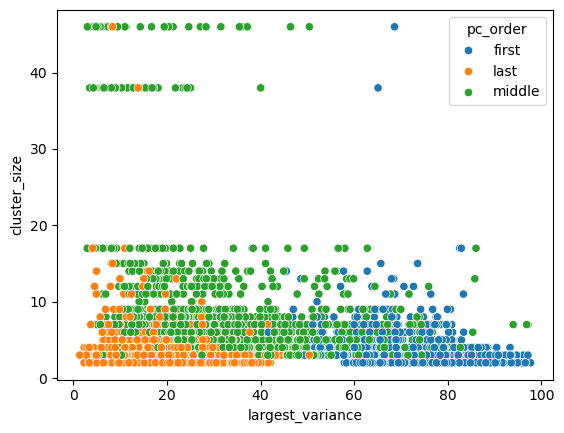

In [ ]:
sns.scatterplot(pc_df, x='largest_variance', y='cluster_size', hue='pc_order')

expression level

In [30]:
def load_avg_exression(avg_expression_path = f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv'):
    tissue_avg_expression = pd.read_csv(avg_expression_path, sep='\t', index_col=0)
    return tissue_avg_expression

def annotate_avg_expression(vep_df, tissue_avg_expression):
    for idx, row in tqdm(vep_df.iterrows(), total=len(vep_df)):
        transcript_list = row['cluster_id'].split('_')
        cluster_avg_expression = tissue_avg_expression.loc[row['tissue_id'],transcript_list]
        vep_df.loc[idx, 'avg_expression'] = np.mean(cluster_avg_expression)
        vep_df.loc[idx, 'avg_log_expression'] = np.mean(np.log10(cluster_avg_expression))
        vep_df.loc[idx, 'median_expression'] = np.median(cluster_avg_expression)
        vep_df.loc[idx, 'min_expression'] = np.min(cluster_avg_expression)


annotate_avg_expression(vep_df, load_avg_exression())

 ... (more hidden) ...


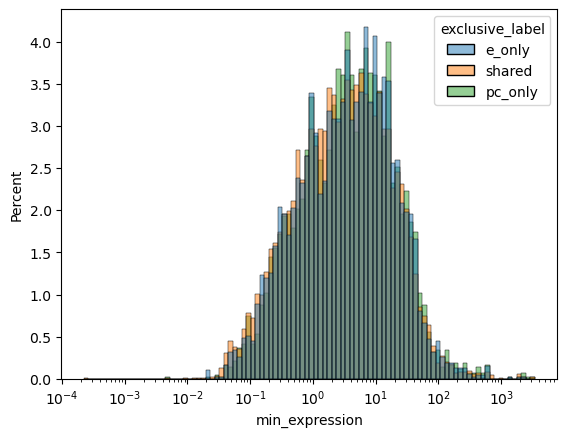

In [39]:
ax=sns.histplot(data=vep_df, hue='exclusive_label', x='min_expression', stat='percent', common_norm=False, bins=100, log_scale=True)


abc

In [40]:
full_abc_path= '/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt.gz'
abc_match_path='/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/ABC_matched_gtex.csv'   
full_abc_pred_df = pd.read_csv(full_abc_path, sep='\t')
abc_gtex_match = pd.read_csv(abc_match_path)

full_abc_pred_df = full_abc_pred_df[full_abc_pred_df['CellType'].isin(abc_gtex_match['ABC_biosample_id'])]
gene_enhancer_df = pd.merge(full_gencode[['transcript_id', 'gene_name']], full_abc_pred_df[['chr', 'start', 'end', 'TargetGene','name','class', 'ABC.Score', 'CellType']], left_on='gene_name', right_on='TargetGene', how='left')
gene_enhancer_df.rename(columns={'name':'enhancer'}, inplace=True)
gene_enhancer_df.set_index('transcript_id', inplace=True)
gene_enhancer_df.dropna(inplace=True)

gene_enhancer_df['chr'] = gene_enhancer_df['chr'].str.split('chr').str[1]
gene_enhancer_df = gene_enhancer_df[gene_enhancer_df['chr'].isin(f'{i+1}' for i in range(22))]
gene_enhancer_df['chr'] = gene_enhancer_df['chr'].astype(int)
gene_enhancer_df['enhancer_start'] = gene_enhancer_df['enhancer'].str.split(':').str[1].str.split('-').str[0].astype(int)
gene_enhancer_df['enhancer_end'] = gene_enhancer_df['enhancer'].str.split(':').str[1].str.split('-').str[1].astype(int)

<AxesSubplot: xlabel='enhancer_size', ylabel='Count'>

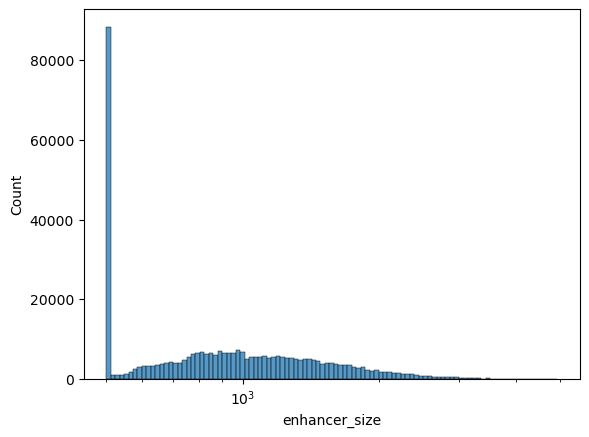

In [41]:
gene_enhancer_df['enhancer_size'] = gene_enhancer_df['enhancer_end'] - gene_enhancer_df['enhancer_start']
sns.histplot(gene_enhancer_df['enhancer_size'], log_scale=True)

In [214]:
for tissue_id, sub_vep in vep_df.groupby('tissue_id'):
    tissue_enhancers = gene_enhancer_df[gene_enhancer_df['CellType'] == abc_gtex_match[abc_gtex_match['GTEX_tissue'] == tissue_id]['ABC_biosample_id'].iloc[0]]
    print(tissue_id)
    print(len(tissue_enhancers))
    for idx, qtl_row in tqdm(sub_vep.iterrows(), total=len(sub_vep)):
        matched_enhancers = tissue_enhancers[(tissue_enhancers['chr'] == qtl_row['#CHROM'])&(tissue_enhancers['enhancer_start'] <= qtl_row['POS'])&(tissue_enhancers['enhancer_end'] >= qtl_row['POS'])]
        all_enhancers = gene_enhancer_df[(gene_enhancer_df['chr'] == qtl_row['#CHROM'])&(gene_enhancer_df['enhancer_start'] <= qtl_row['POS'])&(gene_enhancer_df['enhancer_end'] >= qtl_row['POS'])]

        # is qtl in any abc enhancer?
        vep_df.loc[idx, 'qtl_num_abc_enhancers'] = matched_enhancers['enhancer'].nunique()
        vep_df.loc[idx, 'qtl_num_abc_all_enhancers'] = all_enhancers['enhancer'].nunique()
        # how many genes does the enhancer contact?
        vep_df.loc[idx, 'qtl_num_abc_genes'] = matched_enhancers['TargetGene'].nunique()
        vep_df.loc[idx, 'qtl_num_abc_all_genes'] = all_enhancers['TargetGene'].nunique()
        # how many cluster genes?
        vep_df.loc[idx, 'qtl_matched_abc_genes'] = pd.Series(matched_enhancers.reset_index()['transcript_id'].unique()).isin(qtl_row['cluster_id'].split('_')).sum()
        vep_df.loc[idx, 'qtl_matched_abc_all_genes'] = pd.Series(all_enhancers.reset_index()['transcript_id'].unique()).isin(qtl_row['cluster_id'].split('_')).sum()


Adipose_Subcutaneous
47836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2489/2489 [00:18<00:00, 137.52it/s]


Adipose_Visceral_Omentum
0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1749/1749 [00:11<00:00, 148.15it/s]


Artery_Tibial
46844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2716/2716 [00:18<00:00, 143.14it/s]


Cells_Cultured_fibroblasts
47242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2767/2767 [00:19<00:00, 141.11it/s]


Esophagus_Mucosa
0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:16<00:00, 148.18it/s]


Esophagus_Muscularis
0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1969/1969 [00:13<00:00, 150.20it/s]


Lung
43697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2012/2012 [00:13<00:00, 145.91it/s]


Muscle_Skeletal
47659


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2645/2645 [00:18<00:00, 140.05it/s]


Nerve_Tibial
0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2880/2880 [00:19<00:00, 147.58it/s]


Skin_Not_Sun_Exposed_Suprapubic
47964


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2255/2255 [00:15<00:00, 143.98it/s]


Skin_Sun_Exposed_Lower_leg
44610


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2944/2944 [00:19<00:00, 149.30it/s]


Thyroid
46759


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3514/3514 [00:24<00:00, 145.78it/s]


Whole_Blood
0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2756/2756 [00:18<00:00, 150.99it/s]


In [216]:
print('total qtls: {}'.format(len(vep_df)))
print('qtls with enhancers in matched tissue: {}'.format((vep_df['qtl_num_abc_enhancers'] > 0).sum()))
print('qtls with enhancers in any tissue: {}'.format((vep_df['qtl_num_abc_all_enhancers'] > 0).sum()))

print('qtls with cluster regulating enhancers in matched tissue: {}'.format((vep_df['qtl_matched_abc_genes'] > 0).sum()))
print('qtls with cluster regulating enhancers in any tissue: {}'.format((vep_df['qtl_matched_abc_all_genes'] > 0).sum()))


total qtls: 33078
qtls with enhancers in matched tissue: 324
qtls with enhancers in any tissue: 1593
qtls with cluster regulating enhancers in matched tissue: 123
qtls with cluster regulating enhancers in any tissue: 606


Text(0.5, 1.0, 'Matched tissue E-P connections (for qtls in an enhancer)')

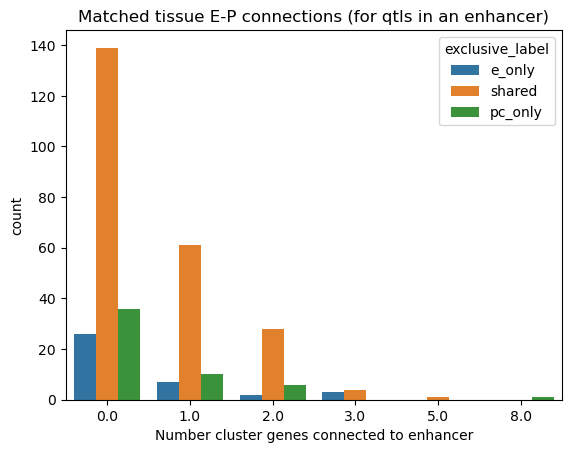

In [221]:
ax = sns.countplot(data=vep_df[vep_df['qtl_num_abc_enhancers'] > 0], hue='exclusive_label', x='qtl_matched_abc_genes')
plt.xlabel('Number cluster genes connected to enhancer')
plt.title('Matched tissue E-P connections (for qtls in an enhancer)')

Text(0.5, 1.0, 'Any tissue E-P connections (for qtls in an enhancer)')

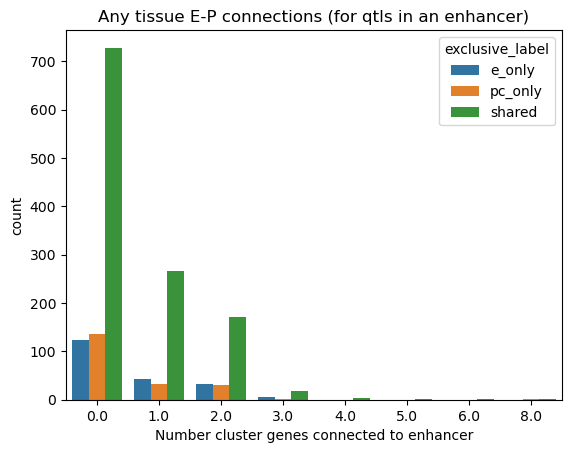

In [220]:
ax = sns.countplot(data=vep_df[vep_df['qtl_num_abc_all_enhancers'] > 0], hue='exclusive_label', x='qtl_matched_abc_all_genes')
plt.xlabel('Number cluster genes connected to enhancer')
plt.title('Any tissue E-P connections (for qtls in an enhancer)')

In [227]:
# try annotating for any of the variants in the credible set

for tissue_id, sub_vep in vep_df.groupby('tissue_id'):
    tissue_enhancers = gene_enhancer_df[gene_enhancer_df['CellType'] == abc_gtex_match[abc_gtex_match['GTEX_tissue'] == tissue_id]['ABC_biosample_id'].iloc[0]]
    print(tissue_id)
    print(len(tissue_enhancers))
    for idx, qtl_row in tqdm(sub_vep.iterrows(), total=len(sub_vep)):
        matched_enhancers=[]
        all_enhancers=[]
        for var in ast.literal_eval(qtl_row['variant_list']):
            var_pos = int(var.split('_')[1])
            matched_enhancers.append(tissue_enhancers[(tissue_enhancers['chr'] == qtl_row['#CHROM'])&(tissue_enhancers['enhancer_start'] <= var_pos)&(tissue_enhancers['enhancer_end'] >= var_pos)])
            all_enhancers.append(gene_enhancer_df[(gene_enhancer_df['chr'] == qtl_row['#CHROM'])&(gene_enhancer_df['enhancer_start'] <=var_pos)&(gene_enhancer_df['enhancer_end'] >= var_pos)])
        matched_enhancers = pd.concat(matched_enhancers)
        all_enhancers = pd.concat(all_enhancers)

        # is qtl in any abc enhancer?
        vep_df.loc[idx, 'cs_qtl_num_abc_enhancers'] = matched_enhancers['enhancer'].nunique()
        vep_df.loc[idx, 'cs_qtl_num_abc_all_enhancers'] = all_enhancers['enhancer'].nunique()
        # how many genes does the enhancer contact?
        vep_df.loc[idx, 'cs_qtl_num_abc_genes'] = matched_enhancers['TargetGene'].nunique()
        vep_df.loc[idx, 'cs_qtl_num_abc_all_genes'] = all_enhancers['TargetGene'].nunique()
        # how many cluster genes?
        vep_df.loc[idx, 'cs_qtl_matched_abc_genes'] = matched_enhancers.reset_index()['transcript_id'].isin(qtl_row['cluster_id'].split('_')).sum()
        vep_df.loc[idx, 'cs_qtl_matched_abc_all_genes'] = all_enhancers.reset_index()['transcript_id'].isin(qtl_row['cluster_id'].split('_')).sum()

Adipose_Subcutaneous
47836


  4%|████████                                                                                                                                                                                                                         | 89/2489 [00:05<04:11,  9.53it/s]

Text(0.5, 1.0, 'Matched tissue E-P connections (for qtls in an enhancer)')

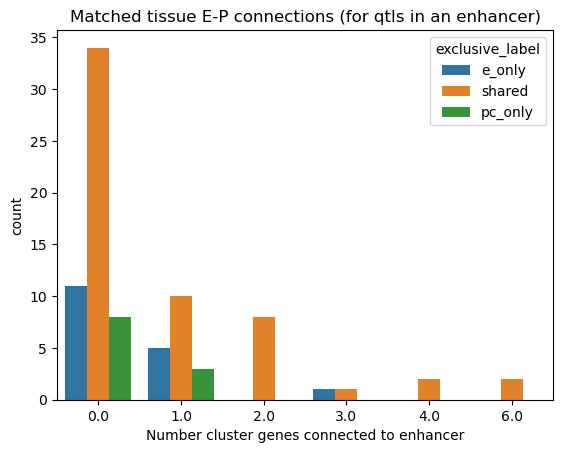

In [226]:
ax = sns.countplot(data=vep_df.loc[small_vep.index][vep_df.loc[small_vep.index]['cs_qtl_num_abc_enhancers'] > 0], hue='exclusive_label', x='cs_qtl_matched_abc_genes')
plt.xlabel('Number cluster genes connected to enhancer')
plt.title('Matched tissue E-P connections (for qtls in an enhancer) for all of cs')

In [ ]:
# very few have any match at all 
vep_df[vep_df['qtl_matched_abc_genes']>2]


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,cs_full_id,variant_list,...,consequence_set,cluster_size_clip,tf_set,avg_expression,avg_log_expression,median_expression,min_expression,qtl_num_abc_enhancers,qtl_num_abc_genes,qtl_matched_abc_genes
1109,16,56643842,chr16_56643842_G_A_b38,G,A,.,.,CSQ=A|downstream_gene_variant|MODIFIER|MT1A|EN...,ENSG00000125144.13_ENSG00000125148.6_ENSG00000...,"['chr16_56643842_G_A_b38', 'chr16_56644113_G_A...",...,"[non_coding_transcript_variant, upstream_gene_...",5,[],313.347253,1.879750,142.940671,0.974389,1.0,40.0,8.0
2942,7,27138127,chr7_27138127_C_T_b38,C,T,.,.,CSQ=T|downstream_gene_variant|MODIFIER|HOXA5|E...,ENSG00000105996.6_ENSG00000105997.22_ENSG00000...,"['chr7_27109480_T_C_b38', 'chr7_27111015_T_C_b...",...,"[non_coding_transcript_variant, upstream_gene_...",5,[],4.070279,0.530270,5.127022,1.345628,1.0,10.0,5.0
2944,7,27157700,chr7_27157700_A_G_b38,A,G,.,.,CSQ=G|upstream_gene_variant|MODIFIER|HOXA7|ENS...,ENSG00000105996.6_ENSG00000105997.22_ENSG00000...,"['chr7_27152469_A_AGGCCT_b38', 'chr7_27157700_...",...,"[regulatory_region_variant, upstream_gene_vari...",5,[],4.070279,0.530270,5.127022,1.345628,1.0,4.0,3.0
8197,6,32936262,chr6_32936262_T_A_b38,T,A,.,.,CSQ=A|intron_variant|MODIFIER|HLA-DMB|ENSG0000...,ENSG00000204252.13_ENSG00000204257.14_ENSG0000...,"['chr6_32936262_T_A_b38', 'chr6_32936274_C_T_b...",...,"[regulatory_region_variant, non_coding_transcr...",4,[],53.254229,1.471331,59.418510,3.163938,1.0,14.0,3.0
9301,11,356080,chr11_356080_T_C_b38,T,C,.,.,CSQ=C|intergenic_variant|MODIFIER|||||||||||||...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,"['chr11_354756_C_G_b38', 'chr11_355039_CTAA_C_...",...,[intergenic_variant],3,[],759.049676,2.755297,865.850932,171.882774,1.0,11.0,3.0
30286,11,353757,chr11_353757_C_T_b38,C,T,.,.,CSQ=T|intergenic_variant|MODIFIER|||||||||||||...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,"['chr11_353757_C_T_b38', 'chr11_354756_C_G_b38...",...,[intergenic_variant],3,[],289.599961,2.412112,226.795521,156.496810,1.0,5.0,3.0
30287,11,353757,chr11_353757_C_T_b38,C,T,.,.,CSQ=T|intergenic_variant|MODIFIER|||||||||||||...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,"['chr11_353757_C_T_b38', 'chr11_354756_C_G_b38...",...,[intergenic_variant],3,[],289.599961,2.412112,226.795521,156.496810,1.0,5.0,3.0
33968,11,327334,chr11_327334_C_T_b38,C,T,.,.,CSQ=T|non_coding_transcript_exon_variant|MODIF...,ENSG00000142089.15_ENSG00000185201.16_ENSG0000...,"['chr11_324880_G_C_b38', 'chr11_325244_C_A_b38...",...,"[non_coding_transcript_variant, TF_binding_sit...",3,"[, FLI1, ETV7, ERF, ETV5, ETV2, SPDEF, ELK1]",638.015041,2.745796,512.479164,308.310906,1.0,3.0,3.0
36582,4,2932581,chr4_2932581_G_A_b38,G,A,.,.,CSQ=A|downstream_gene_variant|MODIFIER|ADD1|EN...,ENSG00000087269.15_ENSG00000109736.14_ENSG0000...,"['chr4_2852886_A_T_b38', 'chr4_2861987_A_G_b38...",...,"[non_coding_transcript_variant, upstream_gene_...",3,[],47.766429,1.363117,16.009146,6.344425,1.0,6.0,3.0


ctcf

In [ ]:

vep_df['tss_min'] = vep_df['POS']
vep_df['tss_max'] = vep_df['POS']
vep_df['Chromosome'] = vep_df['#CHROM']

annotated_vep = []
for tissue_id, sub_vep in vep_df.groupby('tissue_id'):
    ctcf_df = load_ctcf(tissue_id)
    annotate_ctcf(sub_vep, ctcf_df)
    annotated_vep.append(sub_vep)

vep_df =  pd.concat(annotated_vep)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:00<00:00, 788.07it/s]


<AxesSubplot: xlabel='has_ctcf_peak', ylabel='Percent'>

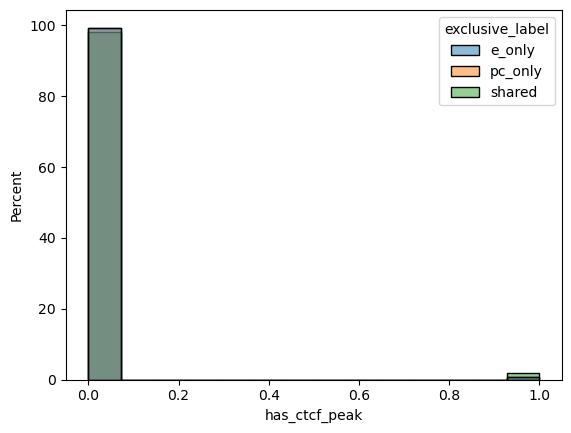

In [ ]:
sns.histplot(data=vep_df, hue='exclusive_label', x='has_ctcf_peak', stat='percent', common_norm=False)

cluster information

In [ ]:
clusters = pd.concat([load_clusters_annotated(config, tissue_id) for tissue_id in tissue_ids])
vep_df = pd.merge(vep_df, clusters, left_on=['cluster_id', 'tissue_id'], right_on=['cluster_id', 'Tissue'])

<AxesSubplot: xlabel='has_high_pos_corr', ylabel='Percent'>

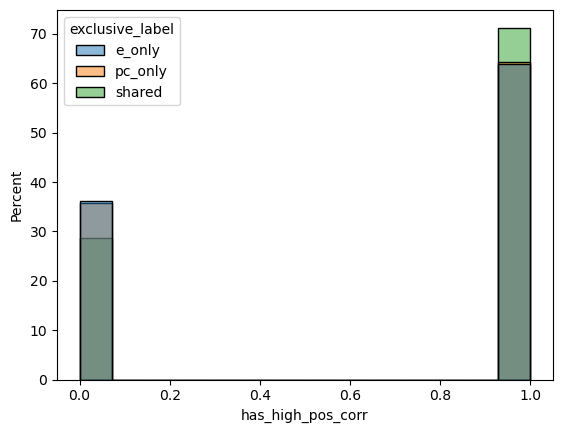

In [ ]:
sns.histplot(data=vep_df, hue='exclusive_label', x='has_high_pos_corr', stat='percent', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Percent'>

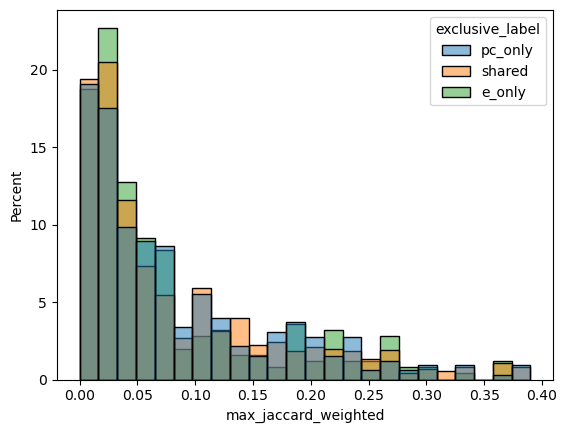

In [ ]:
sns.histplot(data=vep_df[vep_df['num_abc_genes']>1], hue='exclusive_label', x='max_jaccard_weighted', stat='percent', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Percent'>

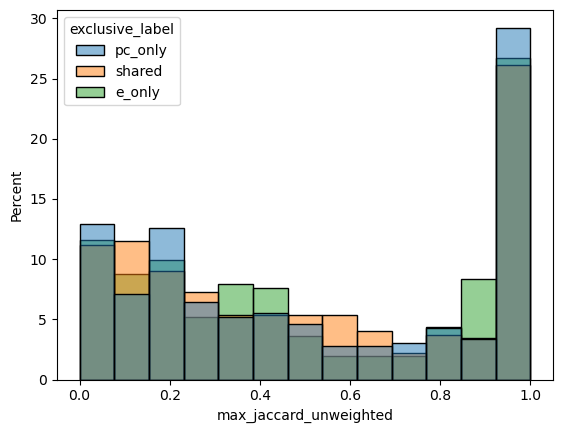

In [ ]:
sns.histplot(data=vep_df[vep_df['num_abc_genes']>1], hue='exclusive_label', x='max_jaccard_unweighted', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_shared_go_all', ylabel='Percent'>

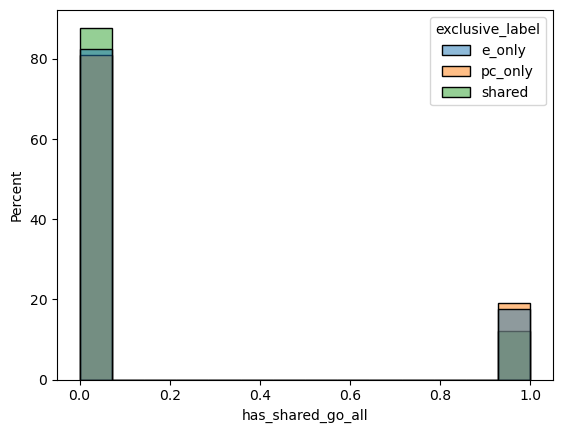

In [ ]:
sns.histplot(data=vep_df, hue='exclusive_label', x='has_shared_go_all', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_cross_map', ylabel='Percent'>

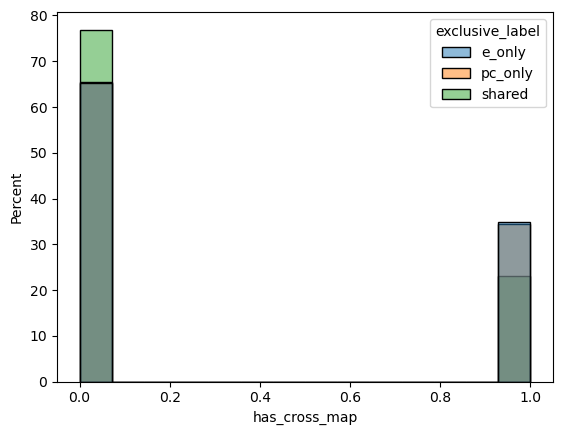

In [ ]:
sns.histplot(data=vep_df, hue='exclusive_label', x='has_cross_map', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_paralog', ylabel='Percent'>

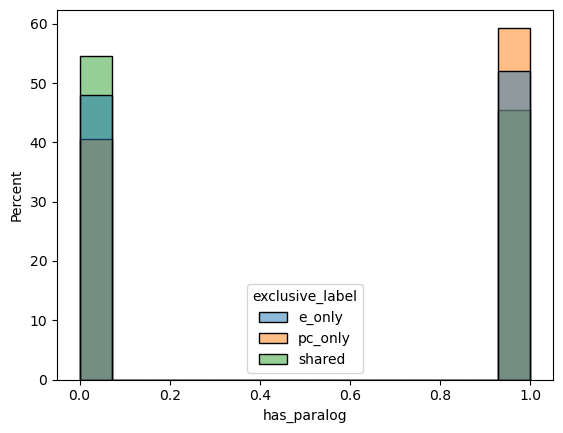

In [ ]:
sns.histplot(data=vep_df, hue='exclusive_label', x='has_paralog', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_shared_strong_enhancers', ylabel='Percent'>

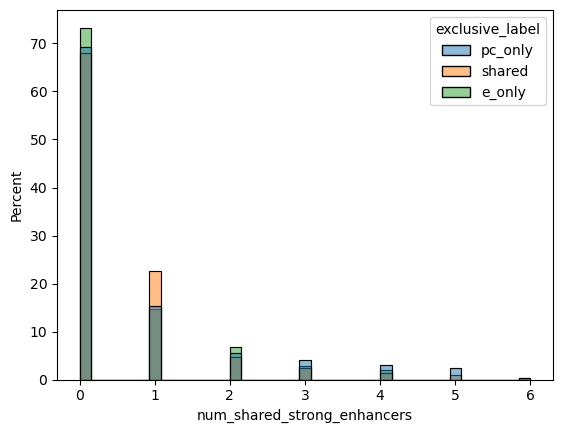

In [ ]:
sns.histplot(data=vep_df[vep_df['num_abc_genes']>1], hue='exclusive_label', x='num_shared_strong_enhancers', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Percent'>

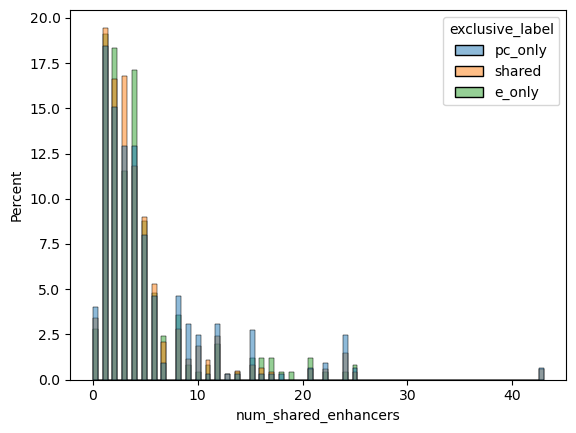

In [ ]:
sns.histplot(data=vep_df[vep_df['num_abc_genes']>1], hue='exclusive_label', x='num_shared_enhancers', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_tads_tss', ylabel='Percent'>

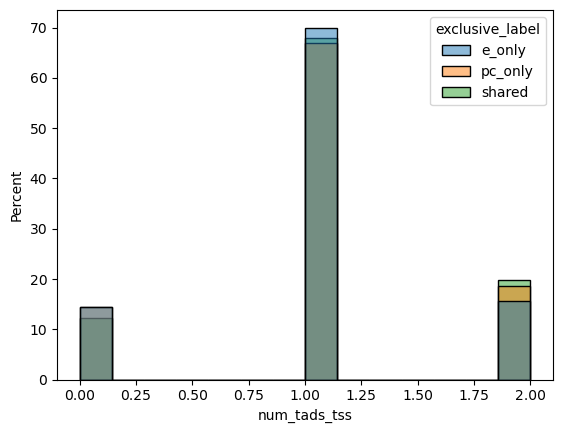

In [ ]:
sns.histplot(data=vep_df, hue='exclusive_label', x='num_tads_tss', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_bidirectional_promoter', ylabel='Percent'>

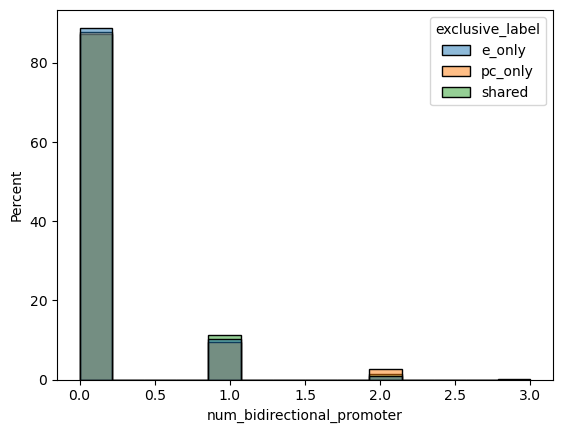

In [ ]:
sns.histplot(data=vep_df, hue='exclusive_label', x='num_bidirectional_promoter', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_abc_genes', ylabel='Percent'>

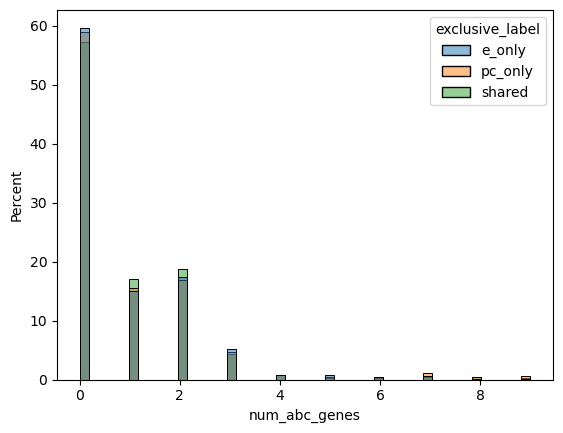

In [ ]:
sns.histplot(data=vep_df, hue='exclusive_label', x='num_abc_genes', stat='percent', common_norm=False)